In [1]:
import time
start = time.time()
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glacierml as gl
from tqdm import tqdm
from scipy import stats
pd.set_option('display.max_column',None)

2024-03-23 22:45:38.515255: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 22:45:38.561137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 22:45:39.178138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Let's do a calculation.
#### ${S} \approx \sum_{k=1}^{N_k} \hat{V}_  k \pm Z^*_{\alpha / 2} \sqrt{\sum_k^{N_k} \sigma^2_k}$

First, let's load data

In [2]:
E_delta_a, areas, cols, train = gl.load_LOO_data(include_train = True)
E_delta_a, areas, cols, df = gl.load_LOO_data(include_train = False)
df[cols] = df[cols]/1e3
train[cols] = train[cols]/1e3
train['Thickness'] = train['Thickness'] / 1e3

#### For the case of independent variables, $\sigma^2_k =  \left(\sigma^H_k\right)^2 \left(\sigma^A_k\right)^2 + {A}_k^2 \left(\sigma^H_k\right)^2 
     +  H_k^2 \left(\sigma^A_k\right)^2$

#### Let $\left(\sigma^H_k\right)^2 = \text{Var}\left(\epsilon^{\mathcal{H}}_k\right) + \text{Var}\left(\epsilon^{\mathcal{R}}_k\right)$,

#### and $\text{Var}\left(\epsilon^{\mathcal{H}}_k\right) \approx \text{Var}_j\left(\mathcal{H}_{kj}\right)$,

#### and $\text{Var}\left(\epsilon^{\mathcal{R}}_B\right) \approx \frac{1}{n_B n_j}\sum_B^{n_B}\sum_{j}^{n_j} \left(r_{jB} - \bar{r}_{B}\right)^2$

In [3]:
### epsilonH is the uncertainty due to limited training data ###
### var(epsilonH) represents variance of  ###
var_eps_H = (1/(len(cols)-1))*np.sum(
    df[cols].sub(np.mean(df[cols],axis = 1),axis = 0)**2,axis = 1
)
df = pd.concat([df,pd.Series(var_eps_H,name = 'var_eps_H')],axis = 1)

In [4]:
### Calculate Var(epsR) ###
### First bin residuals ###
bins = []
[bins.append(x/1e3) for x in range(1, 300, 1)]
bins.append(0)
bins = np.sort(bins).tolist()
names = [str(x) for x in bins]
bins.append(np.inf)
train = pd.concat(
    [
        train,
         pd.cut(train['Thickness'], bins, labels=names).rename('bin')
    ],axis = 1
)
train['bin'] = train['bin'].astype(float)
bins = train['bin'].sort_values().unique().tolist()

In [5]:
### Iterate through residuals and calculate a standard deviation ###
c = dict.fromkeys(bins)
re = dict.fromkeys(bins)

for n,i in tqdm(enumerate(c.keys())):    
    if i <= 170/1e3:
        j = i + 1/1e3
    if i > 170/1e3:
        j = i - 10/1e3
    dft = train[
        (train['bin'] == i)       
               ]
    while len(dft) < 2:
        if i <= 95/1e3:
            j +=1/1e3
            dft = train[
            (train['bin'] >= i)&
            (train['bin'] <= j)       
                   ]
        if i >= 95/1e3 and i < 170/1e3:
            j +=10/1e3
            dft = train[
            (train['bin'] >= i)&
            (train['bin'] <= j)       
                   ]
        if i > 170/1e3:
            j -=10/1e3
            dft = train[
            (train['bin'] <= i)&
            (train['bin'] >= j)       
                   ]
        
    h = (dft[cols])
    r = (h.subtract(dft['Thickness'],axis = 0))
    c[i] = np.std(r.to_numpy().flatten())
    re[i] = np.mean(r)

stds = np.fromiter(c.values(), dtype=float)
reme = np.fromiter(re.values(),dtype=float)

99it [00:02, 44.53it/s]


0.04
0.6


Text(0, 0.5, '$\\sigma^{\\mathcal{R}}_B$ (km)')

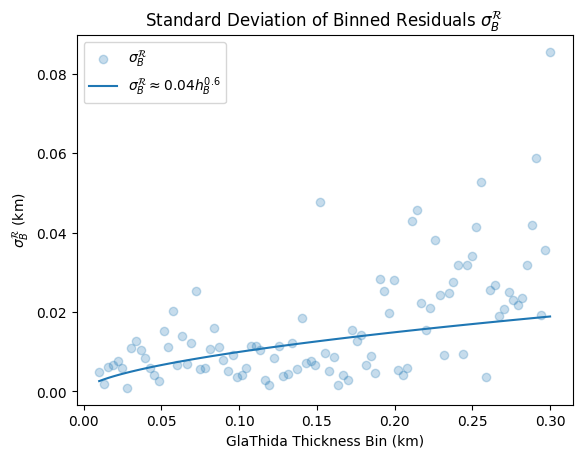

In [6]:
### Fit a statistical model to the range 
z = np.linspace(0.01,0.3,99) 
# z = train['Thickness']
model = np.poly1d(np.polyfit(np.log(z),np.log(stds), 1))

c1 = np.round(np.exp(model[0]),2)
c2 = np.round((model[1]),1)
print(c1)
print(c2)


plt.scatter((z),(stds),alpha = 0.25,label = r'$\sigma^{\mathcal{R}}_B$')
plt.plot((z),np.exp(model(np.log(z))),
                    label = rf'$\sigma^{{\mathcal{{R}}}}_B \approx {c1} h_B^{{{c2}}} $')
plt.legend()
plt.title(r'Standard Deviation of Binned Residuals $\sigma^{\mathcal{R}}_B$')
plt.xlabel('GlaThida Thickness Bin (km)')
plt.ylabel(r'$\sigma^{\mathcal{R}}_B$ (km)')

In [7]:
### Apply statistical model of residuals to mean estimated thickness ###
var_eps_R = (np.mean((c1*df[cols]**c2),axis = 1))**2
df = pd.concat([df,pd.Series(var_eps_R,name = 'var_eps_R')],axis = 1)

In [8]:
### Put them together ###
var_H = var_eps_H + var_eps_R
df = pd.concat([df,pd.Series(var_H,name = 'var_H')],axis = 1)

#### Okay, we have $(\sigma^H_k)^2$ calculated and appended.
#### Let's calculate $(\sigma^A_k)^2$. We follow the procedure set out by Pfeffer et al. 2019.

In [9]:
k = 3
p = 0.7
e1 = 0.039
var_A = (k*e1*(df['Area']**p)**2)
df = pd.concat([df,pd.Series(var_A,name = 'var_A')],axis = 1)

#### That was easy. Now what is left?
#### Let $H_k = \frac{1}{N_j}\sum_{j=1}^{N_j} \mathcal{H}_{kj}$, and $A_k$ be the reported RGI Area

In [10]:
### Calculation for variance of independent variables.  Booooring ###
E_A = df['Area']
E_H = np.mean(df[cols],axis = 1)

v1 = (var_H * var_A)
v2 = (var_H * E_A**2) 
v3 = (E_H**2 * var_A)
sigma_k_ind = v1 + v2 + v3 
df = pd.concat([df,pd.Series(sigma_k_ind,name = 'sig_k_ind')],axis = 1)

#### ${S} \approx \sum_{k=1}^{N_k} \hat{V}_k \pm Z^*_{\alpha / 2} \sqrt{\sum_k^{N_k} \sigma^2_k}$

In [11]:
si = df['sig_k_ind'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

sp = np.sum(si)

se = np.sqrt(sp)

Z = (1.96)
Vlb = np.round( (np.sum(E_H * E_A) - (Z*se)) , 0) / 1e3
Vub = np.round( (np.sum(E_H * E_A) + (Z*se)) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[133.684,137.628]  * 10^3 km^3
Mid CI: 135.656 * 10^3 km^3
CI Half Width: 1.972 * 10^3 km^3


Text(0.5, 1.0, 'Global Glacier Volume Variance Components')

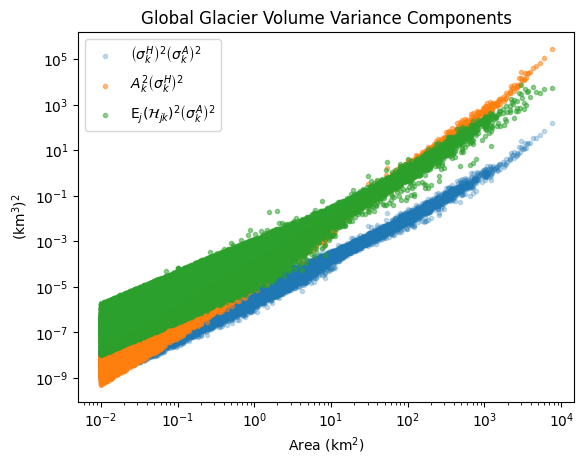

In [12]:
plt.scatter(df['Area'],v1,alpha = 0.25,
            label = r'$\left(\sigma^H_k\right)^2\left(\sigma^A_k\right)^2$',
            marker = '.'
           )
plt.scatter(
    df['Area'],v2,alpha = 0.5,
    label = r'$A_k^2\left(\sigma^{H}_k\right)^2$',
    marker = '.'
)
plt.scatter(
    df['Area'],v3,alpha = 0.5,
    label = r'E$_j\left(\mathcal{H}_{jk}\right)^2\left(\sigma^A_k\right)^2$',
    marker = '.'
)
# plt.scatter(
#     df['Area'],df['Area']*np.mean(df[cols]/1e3,axis = 1),marker = '.',alpha = 0.5,
#     label = 'h*A'
# )
# plt.scatter(df['Area'],np.sqrt(v1+v2+v3),alpha = 0.15,marker = '.',
#            label = r'$\sqrt{\sum}$')
plt.xlabel('Area (km$^2$)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(km$^3$)$^2$')
plt.legend()
plt.title('Global Glacier Volume Variance Components')


Text(0.5, 1.05, 'Global Glacier Volume Uncertainty Assuming No Covariance')

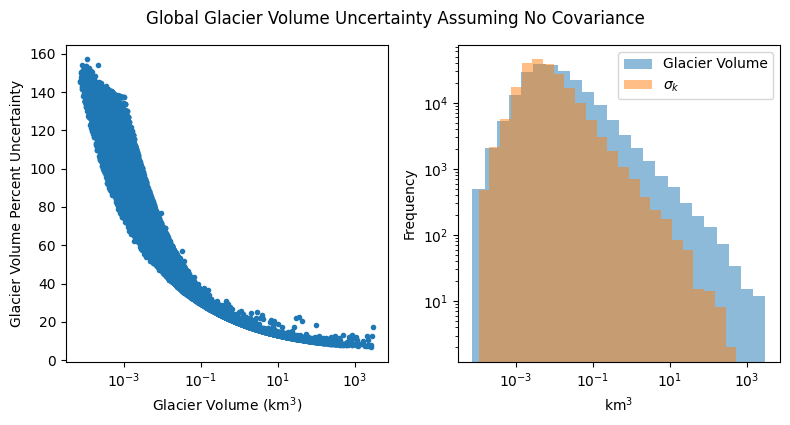

In [13]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

ax[0].scatter(E_H*E_A,(np.sqrt(df['sig_k_ind'])/(E_H*E_A))*100,marker = '.')
ax[0].set_xscale('log')
# plt.yscale('log')
ax[0].set_ylabel('Glacier Volume Percent Uncertainty')
ax[0].set_xlabel('Glacier Volume (km$^3$)')
# ax[0].set_yscale('log')
# ax[0].set_title('Global Glacier Volume Percent Uncertainty')

X = E_H*E_A
Y = np.sqrt(df['sig_k_ind'])

bins_X = np.logspace(np.log10(np.min(X)), np.log10(np.max(X)), 25)
bins_Y = np.logspace(np.log10(np.min(Y)), np.log10(np.max(Y)), 25)

# fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[1].hist(X,bins = bins_X,alpha = 0.5,log = True,label = 'Glacier Volume')
ax[1].hist(Y,bins = bins_Y,alpha = 0.5,log = True,label = r'${\sigma_k}$')
ax[1].set_xscale('log')
ax[1].set_xlabel('km$^3$')
ax[1].set_ylabel('Frequency')
ax[1].legend()
plt.tight_layout()
fig.suptitle('Global Glacier Volume Uncertainty Assuming No Covariance',y = 1.05)

#### Now let's consider covariances.
#### $\sigma_k^2 = \text{Cov}\left(H_k^2,A_k^2\right) - \left[\text{Cov}\left(H_k,A_k\right) + \text{E}\left(H_k\right) \text{E}\left(A_k\right)\right]^2 + \left[\text{Var}\left(H_k\right) + \text{E}\left(H_k\right)\right] \left[\text{Var}\left(A_k\right) + \text{E}\left(A_k\right)\right]$

34.08573126792908


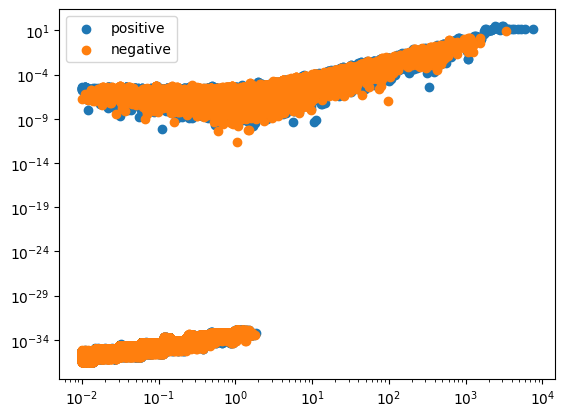

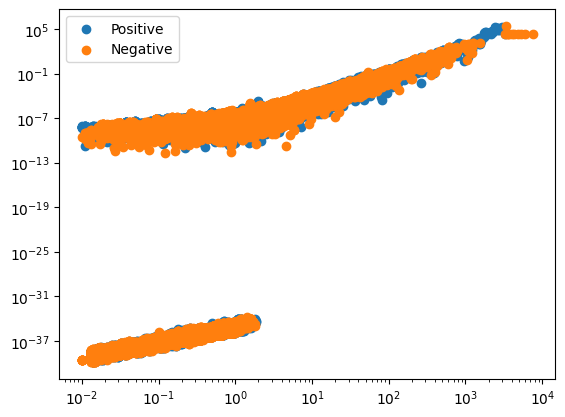

In [14]:

### Calculate Covariances ###
E_H = np.mean(df[cols],axis = 1)
E_A = df['Area']


E_A = np.array(E_A)
E_H = np.array(E_H)

srt = np.argsort(E_A)

### For each glacier in RGI, sample nearby glaciers in size and calculate covarinaces ###

sstart = time.time()
dk = 10
nk = len(E_A)
covsampled = np.zeros(nk)
covsampled2 = np.zeros(nk)

import multiprocessing as mp

def samplecov(kk):
    if kk<dk:
        agroup = E_A[srt][0:2*dk+1]
        hgroup = E_H[srt][0:2*dk+1]
        
    elif nk-kk<dk:
        agroup = E_A[srt][-2*dk-1:-1]
        hgroup = E_H[srt][-2*dk-1:-1]
    else:
        agroup = E_A[srt][kk - dk:kk + dk]
        hgroup = E_H[srt][kk - dk:kk + dk]
#     print(agroup)
#     print(hgroup)
    value =np.cov(agroup,hgroup)[0,1]
    return value

def samplecov2(kk):
    if kk<dk:
        agroup = E_A[srt][0:2*dk+1]**2
        hgroup = E_H[srt][0:2*dk+1]**2
        
    elif nk-kk<dk:
        agroup = E_A[srt][-2*dk-1:-1]**2
        hgroup = E_H[srt][-2*dk-1:-1]**2
    else:
        agroup = E_A[srt][kk - dk:kk + dk]**2
        hgroup = E_H[srt][kk - dk:kk + dk]**2
#     print(agroup)
#     print(hgroup)
    value =np.cov(agroup,hgroup)[0,1]
    return value

# for k in tqdm(range(nk)):
#     covsampled[k] =  samplecov(k) 
with mp.Pool(processes=16) as pool:
    covsampled=pool.map(samplecov,range(nk))
    covsampled2=pool.map(samplecov2,range(nk))
#     break

df = pd.concat(
    [
        df.loc[srt],
        pd.Series(covsampled,name = 'cov',index = srt),
        pd.Series(covsampled2,name = 'cov2',index = srt)
    ],axis = 1
)



endd = time.time()

print(endd-sstart)

plt.scatter(df['Area'].loc[srt],covsampled,label = 'positive')
plt.scatter(df['Area'].loc[srt],-1*np.array(covsampled),label = 'negative')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.scatter(df['Area'].loc[srt],covsampled2,label = 'Positive')
plt.scatter(df['Area'].loc[srt],-1*np.array(covsampled2),label = 'Negative')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

#### Okay, we have covariances, variances, and means.

In [15]:
cov2 = df['cov2']
cov = df['cov']
E_A = df['Area']
E_H = np.mean(df[cols],axis = 1)

### Variance of product of dependent variables ###
# sigma_k_dep = cov2 - (cov + E_H*E_A)**2 + ((var_H + E_H**2) * (var_A + E_A**2))

g1 = cov2
g2 = (cov + E_H*E_A)**2
g3 = ((var_H[srt] + E_H**2) * (var_A[srt] + E_A**2))
sigma_k_dep = g1 - g2 + g3

### Fully expanded ###

# sigma_k_dep = (
#     cov2 - 
#     (cov**2 + 2*cov*E_H*E_A + (E_H*E_A)**2)
#     + (var_H*var_A + var_H*E_A**2 + var_A*E_H**2 + (E_H**2 * E_A**2))
# )

# g1 = cov2
# g2 = cov**2
# g3 = 2*cov*E_H*E_A
# g4 = (E_H*E_A)**2
# g5 = var_H*var_A
# g6 = var_H*E_A**2
# g7 = var_A*E_H**2
# g8 = (E_H**2 * E_A**2)

# sigma_k_dep = g1 - g2 - g3 - g4 + g5 + g6 + g7 + g8

In [16]:
df = pd.concat(
    [
        df,
        pd.Series(sigma_k_dep,name = 'sig_k_dep',index = df.index)
    ],axis = 1
)


In [17]:
### Each glacier is considered a population with variance si ###
si = df['sig_k_dep'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

### Each population has an equal sample size N_j, so pooled global var is the mean var ###
sp = np.sum(si) 
### Standard error of the sampling distribution of sum volume ###
se = np.sqrt(sp)

Z = (1.96)
Vlb = np.round( (np.sum(E_H * E_A) - (Z*se)) , 0) / 1e3
Vub = np.round( (np.sum(E_H * E_A) + (Z*se)) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[133.714,137.598]  * 10^3 km^3
Mid CI: 135.656 * 10^3 km^3
CI Half Width: 1.942 * 10^3 km^3


/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.05, 'Global Glacier Volume Uncertainty Including Covariance')

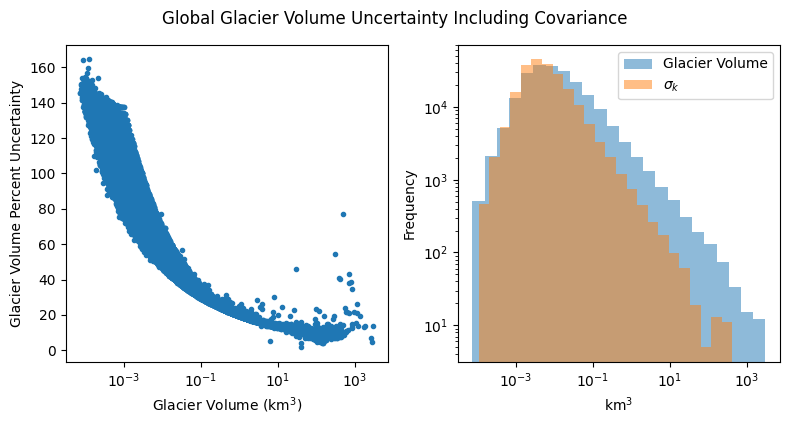

In [18]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

ax[0].scatter(E_H*E_A,(np.sqrt(df['sig_k_dep'])/(E_H*E_A))*100,marker = '.')
ax[0].set_xscale('log')
# plt.yscale('log')
ax[0].set_ylabel('Glacier Volume Percent Uncertainty')
ax[0].set_xlabel('Glacier Volume (km$^3$)')
# ax[0].set_title('Global Glacier Volume Percent Uncertainty')

X = E_H*E_A
Y = np.sqrt(df['sig_k_dep'])

bins_X = np.logspace(np.log10(np.min(X)), np.log10(np.max(X)), 25)
bins_Y = np.logspace(np.log10(np.min(Y)), np.log10(np.max(Y)), 25)

# fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[1].hist(X,bins = bins_X,alpha = 0.5,log = True,label = 'Glacier Volume')
ax[1].hist(Y,bins = bins_Y,alpha = 0.5,log = True,label = r'${\sigma_k}$')
ax[1].set_xscale('log')
ax[1].set_xlabel('km$^3$')
ax[1].set_ylabel('Frequency')
ax[1].legend()
plt.tight_layout()
fig.suptitle('Global Glacier Volume Uncertainty Including Covariance',y = 1.05)

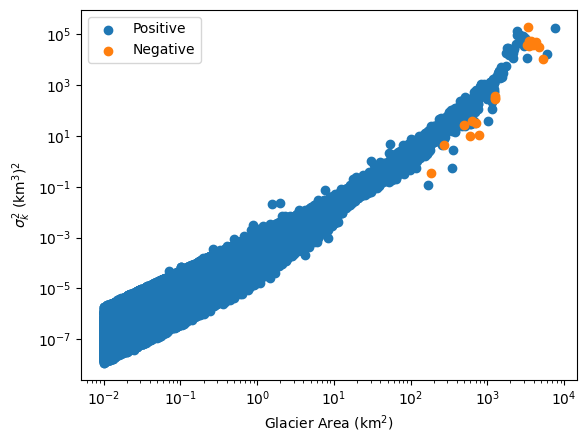

In [19]:
plt.scatter(df['Area'],df['sig_k_dep'],label = 'Positive')
plt.scatter(df['Area'],-df['sig_k_dep'],label = 'Negative')
plt.ylabel(r'$\sigma_k^2$ (km$^3$)$^2$')
plt.xlabel('Glacier Area (km$^2$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

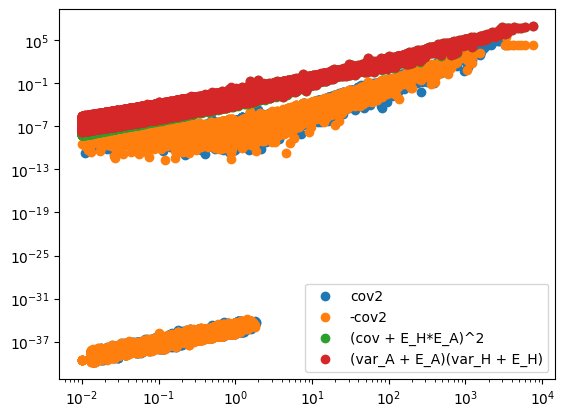

In [20]:
plt.scatter(df['Area'],g1,label = 'cov2')
plt.scatter(df['Area'],-g1,label = '-cov2')



plt.scatter(df['Area'],g2,label = '(cov + E_H*E_A)^2')

plt.scatter(df['Area'],g3,label = '(var_A + E_A)(var_H + E_H)')
plt.yscale('log')
plt.xscale('log')
plt.legend()

0.16668283287375119


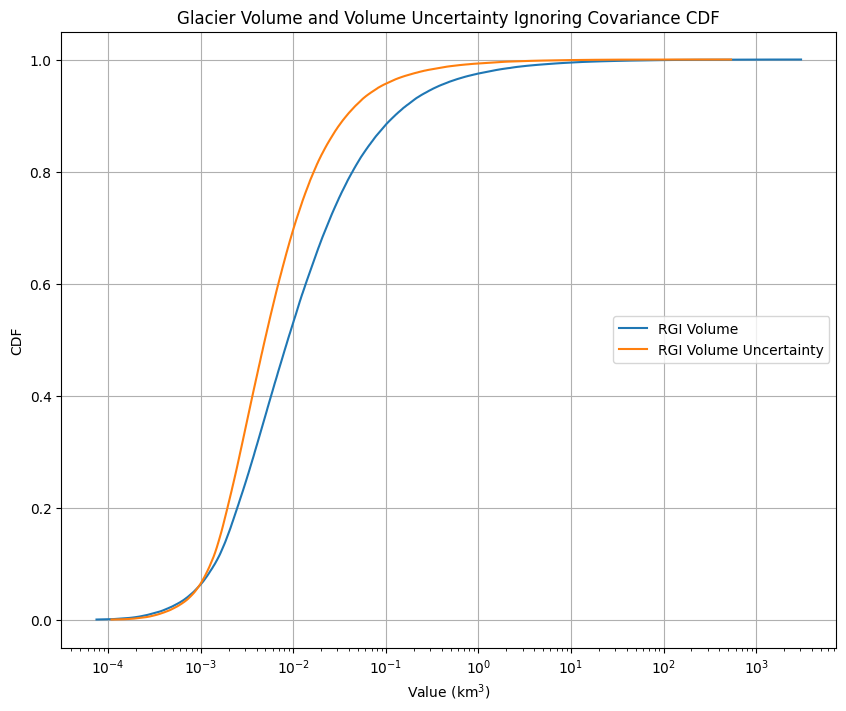

In [21]:
data_1 = np.mean(df[cols],axis = 1) * df['Area']
data_2 = np.sqrt(df['sig_k_ind'])

ks_stat, p_value = stats.ks_2samp(data_1, data_2)
print(ks_stat)
# data_2 = data['FMT'] * data['Area']
#sort data

fig = plt.subplots(1,1,figsize = (10,8))
cdf_data_1 = np.sort(data_1)
cdf_data_2 = np.sort(data_2)


cdf1 = np.arange(len(data_1)) / float(len(data_1))
cdf2 = np.arange(len(data_2)) / float(len(data_2))


plt.plot(cdf_data_1, cdf1, label='RGI Volume')
plt.plot(cdf_data_2, cdf2, label='RGI Volume Uncertainty')


# data_3 = train['Thickness'] * train['Area']
# data_4 = np.sqrt(train['sig_sq_dep'])
# cdf_data_3 = np.sort(data_3)
# cdf_data_4 = np.sort(data_4)


# cdf3 = np.arange(len(data_3)) / float(len(data_3))
# cdf4 = np.arange(len(data_4)) / float(len(data_4))
# ks_stat, p_value = stats.ks_2samp(data_3, data_4)
# print(ks_stat)

# plt.plot(cdf_data_3, cdf3, label='GlaThiDa Volume')
# plt.plot(cdf_data_4, cdf4, label='GlaThiDa Volume Uncertainty')
# plt.plot((ks_stat,ks_stat),(0,1))
plt.title('Glacier Volume and Volume Uncertainty Ignoring Covariance CDF')
plt.xlabel('Value (km$^3$)')
plt.ylabel('CDF')
plt.legend(loc = 'center right')
plt.xscale('log')
plt.grid()
# k = 1
# for lambd in (1,10,100):
#     plt.plot(cdf_data_1, 1 - np.exp(- (cdf_data_1/lambd)**k ),'--')
plt.show()

/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.1666782139574413


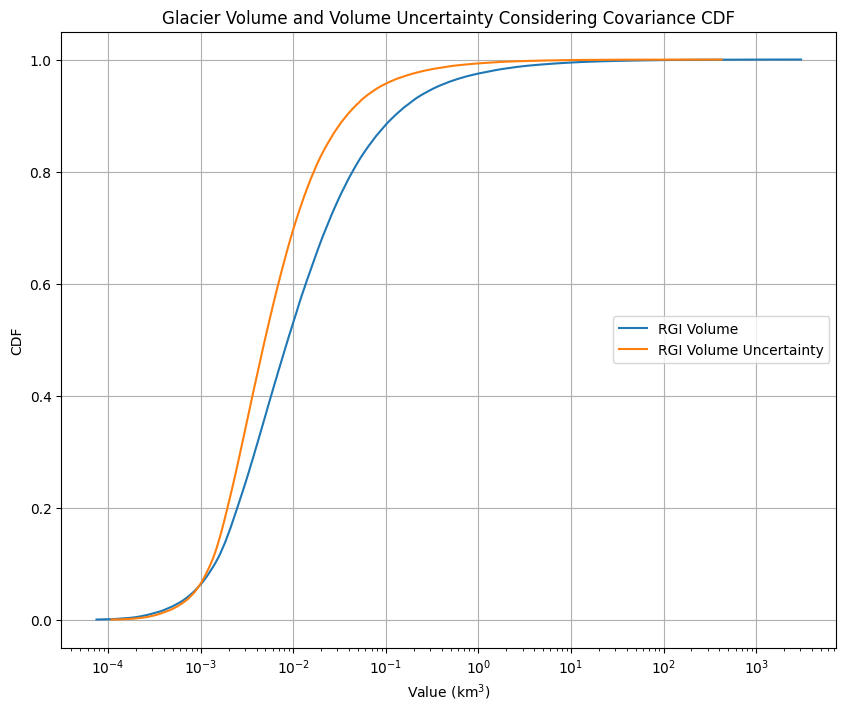

In [22]:
data_1 = np.mean(df[cols],axis = 1) * df['Area']
data_2 = np.sqrt(df['sig_k_dep'])

ks_stat, p_value = stats.ks_2samp(data_1, data_2)
print(ks_stat)
# data_2 = data['FMT'] * data['Area']
#sort data

fig = plt.subplots(1,1,figsize = (10,8))
cdf_data_1 = np.sort(data_1)
cdf_data_2 = np.sort(data_2)


cdf1 = np.arange(len(data_1)) / float(len(data_1))
cdf2 = np.arange(len(data_2)) / float(len(data_2))


plt.plot(cdf_data_1, cdf1, label='RGI Volume')
plt.plot(cdf_data_2, cdf2, label='RGI Volume Uncertainty')


# data_3 = train['Thickness'] * train['Area']
# data_4 = np.sqrt(train['sig_sq_dep'])
# cdf_data_3 = np.sort(data_3)
# cdf_data_4 = np.sort(data_4)


# cdf3 = np.arange(len(data_3)) / float(len(data_3))
# cdf4 = np.arange(len(data_4)) / float(len(data_4))
# ks_stat, p_value = stats.ks_2samp(data_3, data_4)
# print(ks_stat)

# plt.plot(cdf_data_3, cdf3, label='GlaThiDa Volume')
# plt.plot(cdf_data_4, cdf4, label='GlaThiDa Volume Uncertainty')
# plt.plot((ks_stat,ks_stat),(0,1))
plt.title('Glacier Volume and Volume Uncertainty Considering Covariance CDF')
plt.xlabel('Value (km$^3$)')
plt.ylabel('CDF')
plt.legend(loc = 'center right')
plt.xscale('log')
plt.grid()
# k = 1
# for lambd in (1,10,100):
#     plt.plot(cdf_data_1, 1 - np.exp(- (cdf_data_1/lambd)**k ),'--')
plt.show()

In [23]:
end = time.time()
print(end-start)

83.59830260276794


In [24]:
# g1 = cov2
# g2 = (cov + E_H*E_A)**2
# g3 = ((var_H[srt] + E_H**2) * (var_A[srt] + E_A**2))
# sigma_k_dep = g1 - g2 + g3


In [25]:
dft = df[df['sig_k_dep'] < 0]

In [26]:
dft

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,region,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,FMT,Area_unc_0,Area_unc_1,Area_unc_2,Area_unc_3,Area_unc_4,Area_unc_5,Area_unc_6,Area_unc_7,Area_unc_8,Area_unc_9,Area_unc_10,Area_unc_11,Area_unc_12,Area_unc_13,Area_unc_14,Area_unc_15,Area_unc_16,Area_unc_17,Area_unc_18,Area_unc_19,Area_unc_20,Area_unc_21,Area_unc_22,Area_unc_23,Area_unc_24,Area_unc_25,Area_unc_26,Area_unc_27,Area_unc_28,Area_unc_29,Area_unc_30,Area_unc_31,Area_unc_32,Area_unc_33,Area_unc_34,Area_unc_35,Area_unc_36,Area_unc_37,Area_unc_38,Area_unc_39,Area_unc_40,Area_unc_41,Area_unc_42,Area_unc_43,Area_unc_44,Area_unc_45,Area_unc_46,Area_unc_47,Area_unc_48,Area_unc_49,Area_unc_50,Area_unc_51,Area_unc_52,Area_unc_53,Area_unc_54,Area_unc_55,Area_unc_56,Area_unc_57,Area_unc_58,Area_unc_59,Area_unc_60,Area_unc_61,Area_unc_62,Area_unc_63,Area_unc_64,Area_unc_65,Area_unc_66,Area_unc_67,Area_unc_68,Area_unc_69,Area_unc_70,Area_unc_71,Area_unc_72,Area_unc_73,Area_unc_74,Area_unc_75,Area_unc_76,Area_unc_77,Area_unc_78,Area_unc_79,Area_unc_80,Area_unc_81,Area_unc_82,Area_unc_83,Area_unc_84,Area_unc_85,Area_unc_86,Area_unc_87,Area_unc_88,Area_unc_89,Area_unc_90,Area_unc_91,Area_unc_92,Area_unc_93,Area_unc_94,Area_unc_95,Area_unc_96,Area_unc_97,Area_unc_98,Area_unc_99,Area_unc_100,Area_unc_101,Area_unc_102,Area_unc_103,Area_unc_104,Area_unc_105,Area_unc_106,Area_unc_107,Area_unc_108,Area_unc_109,Area_unc_110,Area_unc_111,Area_unc_112,Area_unc_113,Area_unc_114,Area_unc_115,Area_unc_116,Area_unc_117,Area_unc_118,Area_unc_119,Area_unc_120,Area_unc_121,Area_unc_122,Area_unc_123,Area_unc_124,Area_unc_125,Area_unc_126,Area_unc_127,Area_unc_128,Area_unc_129,Area_unc_130,Area_unc_131,Area_unc_132,Area_unc_133,Area_unc_134,Area_unc_135,Area_unc_136,Area_unc_137,Area_unc_138,Area_unc_139,Area_unc_140,Area_unc_141,Area_unc_142,Area_unc_143,Area_unc_144,Area_unc_145,Area_unc_146,Area_unc_147,Area_unc_148,Area_unc_149,Area_unc_150,Area_unc_151,Area_unc_152,Area_unc_153,Area_unc_154,Area_unc_155,Area_unc_156,Area_unc_157,Area_unc_158,Area_unc_159,Area_unc_160,Area_unc_161,Area_unc_162,Area_unc_163,Area_unc_164,Area_unc_165,Area_unc_166,Area_unc_167,Area_unc_168,Area_unc_169,Area_unc_170,Area_unc_171,Area_unc_172,Area_unc_173,Area_unc_174,Area_unc_175,Area_unc_176,Area_unc_177,Area_unc_178,Area_unc_179,Area_unc_180,Area_unc_181,Area_unc_182,Area_unc_183,Area_unc_184,Area_unc_185,Area_unc_186,Area_unc_187,Area_unc_188,Area_unc_189,Area_unc_190,Area_unc_191,Area_unc_192,Area_unc_193,Area_unc_194,Area_unc_195,Area_unc_196,Area_unc_197,Area_unc_198,Area_unc_199,Area_unc_200,Area_unc_201,Area_unc_202,Area_unc_203,Area_unc_204,Area_unc_205,Area_unc_206,Area_unc_207,Area_unc_208,Area_unc_209,Area_unc_210,Area_unc_211,Area_unc_212,Area_unc_213,Area_unc_214,Area_unc_215,Area_unc_216,Area_unc_217,Area_unc_218,Area_unc_219,Area_unc_220,Area_unc_221,Area_unc_222,Area_unc_223,Area_unc_224,Area_unc_225,Area_unc_226,Area_unc_227,A

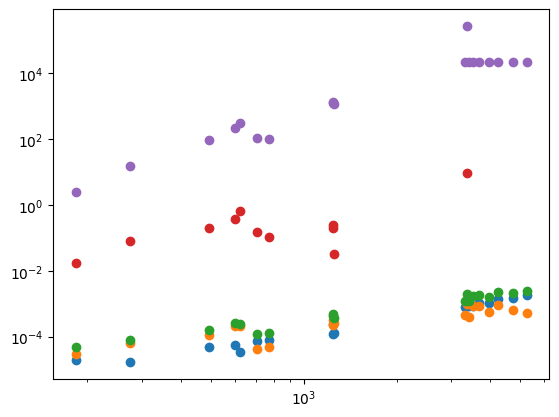

In [27]:
plt.scatter(dft['Area'],dft['var_eps_H'])
plt.scatter(dft['Area'],dft['var_eps_R'])
plt.scatter(dft['Area'],dft['var_H'])
plt.scatter(dft['Area'],-dft['cov'])
plt.scatter(dft['Area'],-dft['cov2'])
plt.xscale('log')
plt.yscale('log')